In [3]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values



In [6]:
float_data[:10]

array([[12.    ,  1.4691],
       [ 6.    ,  1.4691],
       [ 8.    ,  1.4691],
       [ 5.    ,  1.4691],
       [ 8.    ,  1.4691],
       [ 8.    ,  1.4691],
       [ 9.    ,  1.4691],
       [ 7.    ,  1.4691],
       [-5.    ,  1.4691],
       [ 3.    ,  1.4691]], dtype=float32)

In [7]:
# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=300, step_length=500):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 5:]),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 50:]),
                 extract_features(temp[:, -step_length // 100:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=300, step_length=500, val_flag=0):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = []
        while len(rows) < batch_size:
            candidate = np.random.randint(min_index + n_steps * step_length, max_index, size=1)
            #check candidate doesnt cross an earth quake event
            if float_data[candidate-150_000,1] > 20:
                continue
            elif abs(float_data[candidate-150_000,1]- float_data[candidate,1])>1:
                continue
            else:
                rows.append(candidate[0])
        rows = np.array(rows, dtype=np.int)

        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 104677355
first_earthquake = 50085877
#second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, min_index=0*first_earthquake, max_index=first_earthquake+0*second_earthquake, val_flag=1)

# Define model


Our RNN is based on 20 features


In [3]:
#a = [next(valid_gen)[1] for i in range(100)]
#a = np.array(a)
#a = a.flatten()
#import matplotlib.pyplot as plt
#plt.hist(a)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, LSTM, Flatten
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [5]:
# check the uploaded model's performance
#model = load_model('../input/lstmtrial/modelv9.hdf5', custom_objects={'Attention': Attention})
#model.evaluate_generator(valid_gen, steps=100, verbose=1)

In [6]:
# same check but manually done
#k = np.random.randint(150_000, 600_000_000, 1500)
#prediction = np.array([model.predict(np.expand_dims(create_X(float_data[:,0],last_index=i),0)) for i in k])
#actual = np.array([float_data[i-1,1] for i in k])
#difference = np.abs(prediction.flatten() - actual)
#checking = pd.DataFrame(data={'diff' : difference, 'ttf':float_data[k,1]})
#plt.scatter(prediction, float_data[k,1],s=1)

In [7]:
#np.mean(difference)

In [8]:
#model.summary()

In [10]:
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

In [11]:
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim=300,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [12]:
cb = [ModelCheckpoint("modelv9.hdf5", save_best_only=True, period=3)]
#model = load_model('../input/lstmtrial/modelv9.hdf5', custom_objects={'Attention': Attention})

model = Sequential()
#model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(LSTM(150, input_shape=(300, n_features), return_sequences=True, dropout=0.2))
#model.add(Attention(300))
model.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(1))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300, 150)          102600    
_________________________________________________________________
dense_1 (Dense)              (None, 300, 10)           1510      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3001      
Total params: 107,111
Trainable params: 107,111
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].get_weights()[0].shape

(20, 600)

In [ ]:
# Compile and fit model
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=5,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

#Visualize accuracies


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 361s 361ms/step - loss: 2.3556 - val_loss: 2.5875
Epoch 2/5
 365/1000 [=========>....................] - ETA: 5:46 - loss: 2.2409

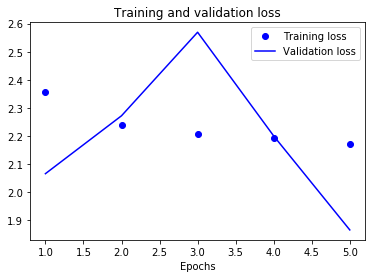

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    plt.savefig('loss_evolution.png')
    return None

perf_plot(history)
plt.savefig('loss_evolution.png')

# Load submission file


In [15]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

100%|██████████| 2624/2624 [10:49<00:00,  4.15it/s]
